In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable

from IPython.display import clear_output
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score


from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler

import random

import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Imputation/CORP_prices_6_years_clean.csv')

In [ ]:
df.reset_index(drop=True, inplace=True)
df['SECURITY'] = df['SECURITY'].replace(5e+9, 0)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    """
    Класс, который грузит данные и будет передавать их в сетку
    to_predict - название признака, который будет предсказываться
    to_drop - столбцы, по которым не нужно предсказывать, оставляю параметром на случай изменения целевых переменных
    df - np.array, not dataframe!
    y - np.array
    """
    def __init__(self, df, y, device):

        self.df = df
        self.y = y
        self.device = device

    def __getitem__(self, idx):
        data = torch.tensor(self.df[idx], dtype=torch.float, device=self.device)
        ans = torch.tensor(self.y[idx], dtype=torch.float, device=self.device)
        return (data, ans)

    def __len__(self):
        return len(self.df)

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
MODEL_PATH = 'checkpoint1.pt' #path to save model, .pt format

In [ ]:
def train_one_epoch(model, train_DataLoader, criterion, optimizer, train_loss, device="cuda:0",
                    verbose=True, verb_every=100):
    """
    verbose - show loss every 100 iterations
    """
    
    model.train()
    
    for i, (data, answers) in tqdm(enumerate(train_DataLoader)):

            data = data.to(device)
            answers = answers.to(device)

            
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, answers.unsqueeze(1))
            loss.backward()
            # clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

           

            train_loss.append(loss.item())

            if verbose:
                if i % verb_every == 0:
                    print(f'Train loss: {np.mean(train_loss[-verb_every:])}' )

    return train_loss   
    

def predict(model, val_DataLoader, criterion, device="cuda:0"):
    model.eval()
    epoch_loss = []
    epoch_accuracy = []
    predictions = []
    real_classes = []

    with torch.no_grad():
        
        for data, answers in tqdm(val_DataLoader):

            data = data.to(device)
            answers = answers.to(device)

            pred =  model(data)     
            loss = criterion(pred, answers.unsqueeze(1))

            epoch_loss.append(loss.item())
            predictions.append(pred)
            real_classes.append(answers)
            

    return epoch_loss, [x.item() for t in predictions for x in t], [x.item() for t in real_classes for x in t]

def draw(train_loss,  val_loss,  batch_num, epoch):
    clear_output(wait=True)
    plt.figure()
    plt.scatter(np.arange(1, len(train_loss) + 1), train_loss, label='train', color='blue', zorder=1)
    plt.scatter(np.arange(1, epoch+2) * batch_num, val_loss, color='red', label='val', zorder=2)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    print(f'epoch: {epoch}')
    

def train(model, train_DataLoader, val_DataLoader, criterion, optimizer, device="cuda:0",
          n_epochs=10, scheduler=None, batch_num=1563, verbose=True, path=MODEL_PATH, verb_every=100):
    """
    batch_num = np.ceil(len(train_dataset)/batch_size)
    path - path to save model
    """
    train_loss = []
    val_loss = []
    es = EarlyStopping(patience=7, path=path)

    for epoch in range(n_epochs):
        train_loss = train_one_epoch(model, train_DataLoader, criterion, optimizer, train_loss, 
                                                     device, verbose=verbose, verb_every=verb_every)
        val_epoch_loss, predictions, classes = predict(model, val_DataLoader, criterion, device)
        val_loss.append(criterion(torch.tensor(classes).unsqueeze(1), torch.tensor(predictions).unsqueeze(1)))
        es(val_loss[-1], model)

        if es.early_stop:
            break

        if scheduler:
            scheduler.step(val_loss[-1])

        draw(train_loss, val_loss, batch_num, epoch)
        print(f'Last val loss: {val_loss[-1]}, best val loss: {min(val_loss)}')

    print(f'Training done')
    print(f'Vall loss: {val_loss[-1]} ')


In [ ]:
class CustomNet(nn.Module):
    """
    n_inputs - количество объясняющих переменных 
    n_hidden_nodes - количество нейронов на каждом из скрытых слоев
    """
    def __init__(self, n_inputs, n_hidden_layers, n_hidden_nodes, dropout, p_dropout=0.5):
        super(CustomNet, self).__init__()

        self.first = nn.Sequential(nn.BatchNorm1d(n_inputs),
                                   nn.Linear(n_inputs, n_hidden_nodes),
                                   nn.BatchNorm1d(n_hidden_nodes),
                                   nn.ReLU())
        if dropout:
            self.hidden = nn.Sequential(*[nn.Sequential(nn.Dropout(p_dropout),
                                                    nn.Linear(n_hidden_nodes, n_hidden_nodes),
                                                    nn.BatchNorm1d(n_hidden_nodes),
                                                    nn.ReLU()) for i in range(n_hidden_layers)])
        else:
            self.hidden = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden_nodes, n_hidden_nodes),
                                                    nn.BatchNorm1d(n_hidden_nodes),
                                                    nn.ReLU()) for i in range(n_hidden_layers)])
        

        self.out = nn.Linear(n_hidden_nodes, 1)

    def forward(self, x):
        return self.out(self.hidden(self.first(x)))

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)

In [ ]:
def mape(y_true, y_pred, weights=None):
    mape = np.abs((y_true-y_pred))/y_true
    return np.average(mape, weights=weights)

In [ ]:
def cross_validate(df, model_price, model_return, folder, scale_x_price=None, scale_x_return=None, scale_y=None):
    
    quals_close = []
    quals_delta = []
    quals_return = []
    imps_close = []
    imps_delta = []
    imps_return = []
    
    for start_ind, split_ind, end_ind in tqdm([(int(len(df[:381251])/10*i), int(len(df[:381251])/10*(i+5)), 
                                           int(len(df[:381251])/10 * (i + 6))) for i in range(5)]):
        
    
        df_train = df[start_ind:split_ind]
        df_test = df[split_ind:end_ind]
        X_train = df_train.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                axis=1).drop([f'delta_{i}' for i in range(2,11)], axis=1)
        
        X_test = df_test.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'],
                              axis=1).drop([f'delta_{i}' for i in range(2,11)], axis=1)

        X_train_return = df_train.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                                          axis=1).drop([f'CLOSE_{i}' for i in range(1,11)], axis=1)
        
        X_test_return = df_test.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                                          axis=1).drop([f'CLOSE_{i}' for i in range(1,11)], axis=1)

        if scale_y:
            y_train_close = scale_y.fit_transform(df_train['CLOSE'].values.reshape(-1,1)).reshape(-1,)
            y_test_close = scale_y.transform(df_test['CLOSE'].values.reshape(-1,1)).reshape(-1,)
            scale_close = scale_y
            y_train_delta = scale_y.fit_transform(df_train['DELTA'].values.reshape(-1,1)).reshape(-1,)
            y_test_delta = scale_y.transform(df_test['DELTA'].values.reshape(-1,1)).reshape(-1,)
            scale_delta = scale_y
            y_train_return = scale_y.fit_transform(df_train['RETURN'].values.reshape(-1,1)).reshape(-1,)
            y_test_return = scale_y.transform(df_test['RETURN'].values.reshape(-1,1)).reshape(-1,)
            scale_return = scale_y
            test = df_test['CLOSE']

        else:
            y_train_close = df_train['CLOSE'].values
            y_test_close = df_test['CLOSE'].values
            y_train_delta = df_train['DELTA'].values
            y_test_delta = df_test['DELTA'].values
            y_train_return = df_train['RETURN'].values
            y_test_return = df_test['RETURN'].values
            

        model_price.fit(X_train, y_train_close, model__sample_weight=df_train['WEIGHT'])
        
        if scale_y:
            pred = scale_close.inverse_transform(model_price.predict(X_test))
            pd.Series(pred).to_csv(f'{folder}/{start_ind}_close.csv', index=False)
            qual_close = [mape(test, pred, df_test['WEIGHT']), 
                      mean_absolute_error(test, pred, sample_weight=df_test['WEIGHT'])]
        else:
            pred = model_price.predict(X_test)
            pd.Series(pred).to_csv(f'{folder}/{start_ind}_close.csv', index=False)
            qual_close = [mape(y_test_close, pred, df_test['WEIGHT']), 
                          mean_absolute_error(y_test_close, pred, sample_weight=df_test['WEIGHT'])]
            
        quals_close.append(qual_close)
        imps_close.append(feature_importance(model_price, X_test, y_test_close, df_test['WEIGHT'], X_test['CLOSE_1'],
                                             target='CLOSE'))

        model_price.fit(X_train, y_train_delta, model__sample_weight=df_train['WEIGHT'])
        
        if scale_y:
                pred = scale_delta.inverse_transform(model_price.predict(X_test)) + df_test['CLOSE_1']
                pd.Series(pred).to_csv(f'{folder}/{start_ind}_delta.csv', index=False)
                qual_delta = [mape(test, pred, df_test['WEIGHT']),
                      mean_absolute_error(test, pred, sample_weight=df_test['WEIGHT'])]
        else:                
            pred = model_price.predict(X_test) + df_test['CLOSE_1']
            pd.Series(pred).to_csv(f'{folder}/{start_ind}_delta.csv', index=False)
            qual_delta = [mape(y_test_close, pred, df_test['WEIGHT']),
                          mean_absolute_error(y_test_close, pred, sample_weight=df_test['WEIGHT'])]
            
        quals_delta.append(qual_delta)
        imps_delta.append(feature_importance(model_price, X_test, y_test_delta, df_test['WEIGHT'], X_test['CLOSE_1'],
                                             target='DELTA'))

        model_return.fit(X_train_return, y_train_return, model__sample_weight=df_train['WEIGHT'])
        
        if scale_y:
            pred = scale_return.inverse_transform(model_return.predict(X_test_return)) * df_test['CLOSE_1'] + df_test['CLOSE_1']
            pd.Series(pred).to_csv(f'{folder}/{start_ind}_return.csv', index=False)
            qual_return = [mape(test, pred, df_test['WEIGHT']),
                       mean_absolute_error(test, pred, sample_weight=df_test['WEIGHT'])]
        else:
            pred = model_return.predict(X_test_return) * df_test['CLOSE_1'] + df_test['CLOSE_1']
            pd.Series(pred).to_csv(f'{folder}/{start_ind}_return.csv', index=False)
            qual_return = [mape(y_test_close, pred, df_test['WEIGHT']),
                           mean_absolute_error(y_test_close, pred, sample_weight=df_test['WEIGHT'])]
            
        quals_return.append(qual_return)
        imps_return.append(feature_importance(model_return, X_test_return, y_test_return, df_test['WEIGHT'], 
                                              X_test['CLOSE_1'], target='RETURN'))

    return quals_close, quals_delta, quals_return, imps_close, imps_delta, imps_return

In [ ]:
def feature_importance(model, X_test, y_test, weights, close, target='CLOSE', device='cpu', scale_y=None):
    imps = []
    
    if target == 'CLOSE':
        model.eval()
        _, pred, _ = predict(model, DataLoader(MyDataset(X_test,y_test, device), batch_size=50), nn.L1Loss(), device=device)
        pred = scale_y.inverse_transform(np.array(pred).reshape(-1,1)).reshape(-1,)
        mape_full = mape(pred, y_test, weights)

        for i in range(X_test.shape[1]):
            _, pred, _ = predict(model, DataLoader(MyDataset(np.hstack((X_test[:, :i], np.zeros((len(X_test),1)), 
                                                     X_test[:, i+1:])), y_test, device), batch_size=50), nn.L1Loss(), device)
            pred = scale_y.inverse_transform(np.array(pred).reshape(-1,1)).reshape(-1,)
            mape_curr = mape(pred, 
                             y_test, weights)
            imps.append(mape_curr - mape_full)
            
    elif target == 'DELTA':
        model.eval()
        _, pred, _ = predict(model, DataLoader(MyDataset(X_test,y_test, device), batch_size=50), nn.L1Loss(), device=device)
        pred = scale_y.inverse_transform(np.array(pred).reshape(-1,1)).reshape(-1,)
        pred = pred + close
        mape_full = mape(pred, y_test, weights)

        for i in range(X_test.shape[1]):
            _, pred, _ = predict(model, DataLoader(MyDataset(np.hstack((X_test[:, :i], np.zeros((len(X_test),1)), 
                                                     X_test[:, i+1:])), y_test, device), batch_size=50), nn.L1Loss(), device)
            pred = scale_y.inverse_transform(np.array(pred).reshape(-1,1)).reshape(-1,)
            pred = pred + close
            mape_curr = mape(pred, 
                             y_test, weights)
            imps.append(mape_curr - mape_full)
    elif target == 'RETURN':
        model.eval()
        _, pred, _ = predict(model, DataLoader(MyDataset(X_test,y_test, device), batch_size=50), nn.L1Loss(), device=device)
        pred = np.array(pred) * close + close
        mape_full = mape(pred, y_test, weights)
        for i in range(X_test.shape[1]):
            _, pred, _ = predict(model, DataLoader(MyDataset(np.hstack((X_test[:, :i], np.zeros((len(X_test),1)), 
                                                     X_test[:, i+1:])), y_test, device), batch_size=50), nn.L1Loss(), device)
            pred = np.array(pred) * close + close
            mape_curr = mape(pred, 
                             y_test, weights)
            imps.append(mape_curr - mape_full)
            
    return imps

In [ ]:
def cross_validate_close(df, folder, batch_size, num_layers, num_nodes, dropout, p_dropout, 
                          optim_class, lr, scale_x=None, scale_y=None, device='cpu'):
    
    imps_return = []
    
    for start_ind, split_ind, end_ind in tqdm([(int(len(df[:381251])/10*i), int(len(df[:381251])/10*(i+5)), 
                                           int(len(df[:381251])/10 * (i + 6))) for i in range(5)]):
        
    
        df_train = df[start_ind:split_ind]
        df_test = df[split_ind:end_ind]

        X_train_return = scale_x.fit_transform(df_train.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                axis=1).drop([f'delta_{i}' for i in range(2,11)], axis=1))
        
        X_test_return = scale_x.transform(df_test.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                axis=1).drop([f'delta_{i}' for i in range(2,11)], axis=1))
        

        y_train_return = scale_y.fit_transform(df_train['CLOSE'].values.reshape(-1,1)).reshape(-1,)
        y_test_return = scale_y.transform(df_test['CLOSE'].values.reshape(-1,1)).reshape(-1, )
        
        train_dataset = MyDataset(X_train_return, y_train_return, device=device)
        test_dataset = MyDataset(X_test_return, y_test_return, device=device)

        train_DataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_DataLoader = DataLoader(test_dataset, batch_size=50, shuffle=False)

        model = CustomNet(X_train_return.shape[1], n_layers, n_nodes, dropout, p_dropout)
        optimizer = optim_class(model.parameters(), lr=lr)
        criterion = nn.L1Loss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

        train(model, train_DataLoader, test_DataLoader, criterion, optimizer, device=device, n_epochs=20, scheduler=scheduler, 
              batch_num=int(len(train_dataset)/batch_size))
        
        model.load_state_dict(torch.load('checkpoint1.pt'))

        _, pred, _ = predict(model, test_DataLoader, criterion, device)
        pred = scale_y.inverse_transform(np.array(pred).reshape(-1,1)).reshape(-1, )
        pd.Series(pred).to_csv(f'{folder}/{start_ind}_close.csv', index=False)

        # imps_return.append(feature_importance(model, X_test_return, scale_y.inverse_transform(y_test_return.reshape(-1,1)).reshape(-1,),
        #                                       df_test['WEIGHT'], df_test['CLOSE_1'].values.reshape(-1, ), scale_y=scale_y,
        #                                       target='CLOSE', device=device))
        

    return imps_return, model, X_test_return, y_test_return, df_test['WEIGHT']          

In [ ]:
def cross_validate_return(df, folder, batch_size, num_layers, num_nodes, dropout, p_dropout, 
                          optim_class, lr, scale_x=None, device='cpu'):
    
    imps_return = []
    
    for start_ind, split_ind, end_ind in tqdm([(int(len(df[:381251])/10*i), int(len(df[:381251])/10*(i+5)), 
                                           int(len(df[:381251])/10 * (i + 6))) for i in range(5)]):
        
    
        df_train = df[start_ind:split_ind]
        df_test = df[split_ind:end_ind]

        X_train_return = scale_x.fit_transform(df_train.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                                          axis=1).drop([f'CLOSE_{i}' for i in range(1,11)], axis=1))
        
        X_test_return = scale_x.transform(df_test.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                                          axis=1).drop([f'CLOSE_{i}' for i in range(1,11)], axis=1))
        

        y_train_return = df_train['RETURN'].values
        y_test_return = df_test['RETURN'].values
        
        train_dataset = MyDataset(X_train_return, y_train_return, device=device)
        test_dataset = MyDataset(X_test_return, y_test_return, device=device)

        train_DataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_DataLoader = DataLoader(test_dataset, batch_size=50, shuffle=False)

        model = CustomNet(X_train_return.shape[1], n_layers, n_nodes, dropout, p_dropout)
        optimizer = optim_class(model.parameters(), lr=lr)
        criterion = nn.L1Loss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

        train(model, train_DataLoader, test_DataLoader, criterion, optimizer, device=device, n_epochs=20, scheduler=scheduler, 
              batch_num=int(len(train_dataset)/batch_size))
        
        model.load_state_dict(torch.load('checkpoint1.pt'))

        _, pred, _ = predict(model, test_DataLoader, criterion, device)
        pred = np.array(pred) * df_test['CLOSE_1'] + df_test['CLOSE_1']
        pd.Series(pred).to_csv(f'{folder}/{start_ind}_return.csv', index=False)

        imps_return.append(feature_importance(model, X_test_return, y_test_return, df_test['WEIGHT'], df_test['CLOSE_1'],
                                              target='RETURN', device=device))
        

    return imps_return, model, X_test_return, y_test_return, df_test['WEIGHT']          

In [ ]:
def cross_validate_delta(df, folder, batch_size, num_layers, num_nodes, dropout, p_dropout, 
                          optim_class, lr, scale_x=None, scale_y=None, device='cpu'):
    
    imps_return = []
    
    for start_ind, split_ind, end_ind in tqdm([(int(len(df[:381251])/10*i), int(len(df[:381251])/10*(i+5)), 
                                           int(len(df[:381251])/10 * (i + 6))) for i in range(5)]):
        
    
        df_train = df[start_ind:split_ind]
        df_test = df[split_ind:end_ind]

        X_train_return = scale_x.fit_transform(df_train.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                axis=1).drop([f'delta_{i}' for i in range(2,11)], axis=1))
        
        X_test_return = scale_x.transform(df_test.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                axis=1).drop([f'delta_{i}' for i in range(2,11)], axis=1))
        

        y_train_return = scale_y.fit_transform(df_train['DELTA'].values.reshape(-1,1)).reshape(-1,)
        y_test_return = scale_y.transform(df_test['DELTA'].values.reshape(-1,1)).reshape(-1, )
        
        train_dataset = MyDataset(X_train_return, y_train_return, device=device)
        test_dataset = MyDataset(X_test_return, y_test_return, device=device)

        train_DataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_DataLoader = DataLoader(test_dataset, batch_size=50, shuffle=False)

        model = CustomNet(X_train_return.shape[1], n_layers, n_nodes, dropout, p_dropout)
        optimizer = optim_class(model.parameters(), lr=lr)
        criterion = nn.L1Loss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

        train(model, train_DataLoader, test_DataLoader, criterion, optimizer, device=device, n_epochs=20, scheduler=scheduler, 
              batch_num=int(len(train_dataset)/batch_size))
        
        model.load_state_dict(torch.load('checkpoint1.pt'))

        _, pred, _ = predict(model, test_DataLoader, criterion, device)
        pred = scale_y.inverse_transform(np.array(pred).reshape(-1,1)).reshape(-1, ) + df_test['CLOSE_1']
        pd.Series(pred).to_csv(f'{folder}/{start_ind}_delta.csv', index=False)

        imps_return.append(feature_importance(model, X_test_return, scale_y.inverse_transform(y_test_return.reshape(-1,1)).reshape(-1,),
                                              df_test['WEIGHT'], df_test['CLOSE_1'].values.reshape(-1, ), scale_y=scale_y,
                                              target='DELTA', device=device))
        

    return imps_return, model, X_test_return, y_test_return, df_test['WEIGHT']          

In [ ]:
device='cpu'
n_layers=4
n_nodes=20
p_dropout=0
dropout=False
lr=0.002
scale_x = MinMaxScaler()
scale_y = MinMaxScaler()
optimizer = torch.optim.Adam
batch_size=50

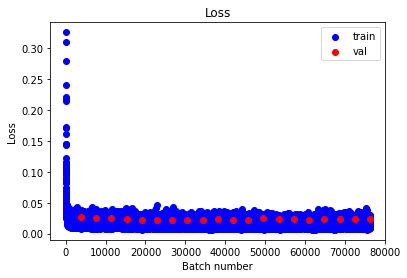

epoch: 19
Last val loss: 0.02297816053032875, best val loss: 0.02234513685107231
Training done
Vall loss: 0.02297816053032875 


In [ ]:
seed_everything(6)
imps_return, model, X_test_return, y_test_return, weight = cross_validate_delta(df, '/content/drive/MyDrive/Imputation/NN_pred',
                                                                                batch_size, n_layers, n_nodes, dropout,
                                    p_dropout, optimizer, lr=lr, scale_x=scale_x, scale_y=scale_y,device='cpu')

In [ ]:
imps_return = np.array(imps_return)

In [ ]:
pd.Series(imps_return.mean(axis=0), name='imps_delta').to_csv('/content/drive/MyDrive/Imputation/Net_importance_delta.csv', index=False)

In [ ]:
device='cpu'
n_layers=4
n_nodes=40
p_dropout=0
dropout=False
lr=0.003
scale_x = MinMaxScaler()
scale_y = MinMaxScaler()
optimizer = torch.optim.Adam
batch_size=100

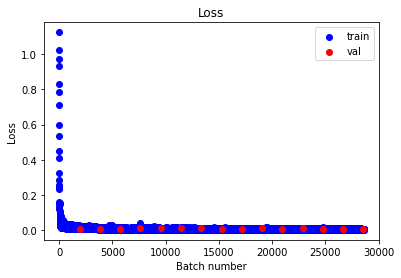

epoch: 14
Last val loss: 0.008607366122305393, best val loss: 0.006222129333764315


Train loss: 0.0050908394763246176
Train loss: 0.005276047203224153
Train loss: 0.005542750051245093
Train loss: 0.004738529867026955
Train loss: 0.005148113362956792
Train loss: 0.005118476399220526
Train loss: 0.004785695152822882
Train loss: 0.005075415300671011
Train loss: 0.005207305017393082
Train loss: 0.004925297063309699
Train loss: 0.005185333543922752
Train loss: 0.0049902454996481535
Train loss: 0.0051584554323926566
Train loss: 0.004920339323580265
Train loss: 0.004998881763312966
Train loss: 0.004926386706065386
Train loss: 0.005055281755048781
Train loss: 0.005429759551770985
Train loss: 0.004681565689388663
Train loss: 0.005368711415212601




EarlyStopping counter: 7 out of 7
Training done
Vall loss: 0.009392999112606049 


In [ ]:
imps_return, model, X_test_return, y_test_return, weight = cross_validate_close(df, '/content/drive/MyDrive/Imputation/NN_pred',
                                                                                batch_size, n_layers, n_nodes, dropout,
                                    p_dropout, optimizer, lr=lr, scale_x=scale_x, scale_y=scale_y,device='cpu')

In [ ]:
def predict_all(df, folder, scale_x, scale_y, scale_y_delta, scale_x_return):

    batch_size=100

    seed_everything(6)

    df_train = df[:381251]
    df_test = df[381251:]

    X_train = scale_x.fit_transform(df_train.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                axis=1).drop([f'delta_{i}' for i in range(2,11)], axis=1))
        
    X_test = scale_x.transform(df_test.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                axis=1).drop([f'delta_{i}' for i in range(2,11)], axis=1))
    
    X_train_return = scale_x_return.fit_transform(df_train.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                                          axis=1).drop([f'CLOSE_{i}' for i in range(1,11)], axis=1))
        
    X_test_return = scale_x_return.transform(df_test.drop(['CLOSE', 'DELTA', 'RETURN', 'TRADEDATE', 'WEIGHT'], 
                                                          axis=1).drop([f'CLOSE_{i}' for i in range(1,11)], axis=1))
    
    y_train_close = scale_y.fit_transform(df_train['CLOSE'].values.reshape(-1,1)).reshape(-1,)
    y_test_close = scale_y.transform(df_test['CLOSE'].values.reshape(-1,1)).reshape(-1, )

    y_train_delta = scale_y_delta.fit_transform(df_train['DELTA'].values.reshape(-1,1)).reshape(-1,)
    y_test_delta = scale_y_delta.transform(df_test['DELTA'].values.reshape(-1,1)).reshape(-1, )

    y_train_return = df_train['RETURN'].values
    y_test_return = df_test['RETURN'].values

    tr_d_c = MyDataset(X_train, y_train_close, device)
    test_d_c = MyDataset(X_test, y_train_close, device)
    train_DataLoader_close = DataLoader(tr_d_c, batch_size=100, shuffle=True, drop_last=True)
    test_DataLoader_close = DataLoader(test_d_c, batch_size=100)


    tr_d_d = MyDataset(X_train, y_train_return, device)
    test_d_d = MyDataset(X_test, y_train_return, device)
    train_DataLoader_delta = DataLoader(tr_d_d, batch_size=50, shuffle=True, drop_last=True)
    test_DataLoader_delta = DataLoader(test_d_d, batch_size=100)

    tr_d_r = MyDataset(X_train_return, y_train_return, device)
    test_d_r = MyDataset(X_test_return, y_train_return, device)
    train_DataLoader_return = DataLoader(tr_d_r, batch_size=100, shuffle=True, drop_last=True)
    test_DataLoader_return = DataLoader(test_d_r, batch_size=100)

    model_close = CustomNet(X_train.shape[1], 4, 40, dropout=False)
    model_delta = CustomNet(X_train.shape[1], 4, 20, dropout=False)
    model_return = CustomNet(X_train_return.shape[1], 1, 20, dropout=False)

    optim_close = torch.optim.Adam(model_close.parameters(), lr=0.003)
    optim_delta = torch.optim.Adam(model_delta.parameters(), lr=0.002)
    optim_return = torch.optim.Adam(model_return.parameters(), lr=0.009)

    scheduler_close = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_close)
    scheduler_delta = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_delta)
    scheduler_return = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_return)

    criterion = nn.L1Loss()

    # train(model_close, train_DataLoader_close, test_DataLoader_close, criterion, optim_close, device=device, n_epochs=20, scheduler=scheduler_close, 
    #           batch_num=int(len(tr_d_c)/batch_size))
    
    # model_close.load_state_dict(torch.load('checkpoint1.pt'))

    # _, pred, _ = predict(model_close, test_DataLoader_close, criterion, device)
    # pred = scale_y.inverse_transform(np.array(pred).reshape(-1,1)).reshape(-1, )
    # pd.Series(pred).to_csv(f'{folder}/full_close.csv', index=False)

    # train(model_delta, train_DataLoader_delta, test_DataLoader_delta, criterion, optim_delta, device=device, n_epochs=20, scheduler=scheduler_delta, 
    #           batch_num=int(len(tr_d_c)/batch_size))
    
    # model_delta.load_state_dict(torch.load('checkpoint1.pt'))

    # _, pred, _ = predict(model_delta, test_DataLoader_delta, criterion, device)
    # pred = scale_y_delta.inverse_transform(np.array(pred).reshape(-1,1)).reshape(-1, )
    # pred = pred + df_test['CLOSE_1']
    # pd.Series(pred).to_csv(f'{folder}/full_delta.csv', index=False)

    train(model_return, train_DataLoader_return, test_DataLoader_return, criterion, optim_return, device=device, n_epochs=20, scheduler=scheduler_return, 
              batch_num=int(len(tr_d_c)/batch_size))
    
    model_return.load_state_dict(torch.load('checkpoint1.pt'))

    _, pred, _ = predict(model_return, test_DataLoader_return, criterion, device)
    pred = np.array(pred).reshape(-1,) * df_test['CLOSE_1'] + df_test['CLOSE_1']
    pd.Series(pred).to_csv(f'{folder}/full_return.csv', index=False)

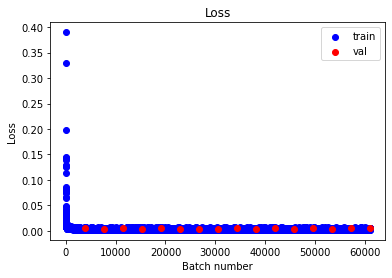

epoch: 15
Last val loss: 0.004675955977290869, best val loss: 0.004156091250479221


Train loss: 0.0037406395957805217
Train loss: 0.0037238003336824478
Train loss: 0.00385455968324095
Train loss: 0.003840260144788772
Train loss: 0.0037588636903092263
Train loss: 0.0038007765170186758
Train loss: 0.0037240618793293835
Train loss: 0.0037218005838803945
Train loss: 0.003684052799362689
Train loss: 0.0038911924394778906
Train loss: 0.0036568052694201467
Train loss: 0.0037372395512647928
Train loss: 0.0037911373004317285
Train loss: 0.003833600739017129
Train loss: 0.0037657089927233757
Train loss: 0.0038201276399195193
Train loss: 0.003977372359950096
Train loss: 0.0038686376740224657
Train loss: 0.003694093655794859
Train loss: 0.0038383495528250934
Train loss: 0.0038362295110709963
Train loss: 0.003824501074850559
Train loss: 0.0036785168503411115
Train loss: 0.0038290047529153525
Train loss: 0.003722565092612058
Train loss: 0.003906943509355188
Train loss: 0.003945732193533331
Train loss: 0.0036595539329573514
Train loss: 0.003812977515626699
Train loss: 0.003901049823


EarlyStopping counter: 7 out of 7
Training done
Vall loss: 0.0048063695430755615 


In [ ]:
predict_all(df, '/content/drive/MyDrive/Imputation/NN_pred', scale_x=MinMaxScaler(), scale_y=MinMaxScaler(), scale_x_return=StandardScaler(), scale_y_delta=MinMaxScaler())